# Household dust data

A problem in linear regression, using the `homes.Rdata` dataset, extracted from the [Homes_USA](http://figshare.com/articles/1000homes/1270900) repository of data analyzed in the paper [Barberan et al. (2015), _"The ecology of microscopic life in household dust",_](https://royalsocietypublishing.org/doi/full/10.1098/rspb.2015.1139) Proceedings of the Royal Society B, Biological Sciences Volume 282, Issue 1814.
	
The data are dust samples from the ledges above doorways from $n=1,059$ homes (after removing samples with missing data) in the continental US. Bioinformatics processing detects the presence or absence of $763$ species (technically operational taxonomic units) of fungi. The response is the log of the number of fungi species present in the sample, which is a measure of species richness. The objective is to determine which factors influence a home's species richness. For each home, eight covariates are included in this example: 

01. `long`:     Longitude,
02. `lat`:      Latitude,
03. `temp`:     Temperature,
04. `precip`:   Precipitation,
05. `NPP`:      Net Primary Productivity (NPP) (See the  [Appendix](https://www.pnas.org/content/pnas/suppl/2015/04/15/1420815112.DCSupplemental/pnas.1420815112.sapp.pdf)),
06. `elev`:     Elevation,
07. `house`:    Single-family home (binary indicator),
08. `bedrooms`: Number of bedrooms.

Notebook made by: Eric Duque, Arnau Gris and Angel Morales

In [1]:
# Load data (there is a warning about NAs. It's OK, later on we remove them)
load("homes.RData")

lat      <- homes[,4]
long     <- homes[,5]
temp     <- homes[,6]
precip   <- homes[,7]
NPP      <- homes[,8]
elev     <- homes[,9]
house    <- ifelse(homes[,10]=="One-family house detached from any other house",1,0) # Convert to an indicator
bedrooms <- as.numeric(homes[,11])

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

In [2]:
city     <- homes[,2]
state    <- homes[,3]

OTU      <- as.matrix(OTU)
nspecies <- rowSums(OTU>0)
y        <- log(nspecies)
X        <- cbind(long,lat,temp,precip,NPP,elev,house,bedrooms)
names    <- c("Longitude","Latitude","Temperature","Precipitation","NPP","Elevation","Single-family home",
                "Number of bedrooms")

In [3]:
# Remove observations with missing data

junk     <- is.na(rowSums(X))
y        <- y[!junk]
X        <- X[!junk,]
city     <- city[!junk]
state    <- state[!junk]

In [4]:
# Standardize the covariates

X<- as.matrix(scale(X))
X0<-X
X0.centers<-attr(X0,"scaled:center")
X0.scales<-attr(X0,"scaled:scale")
attr(X,"scaled:center")<-NULL
attr(X,"scaled:scale")<-NULL
str(X0.centers)
str(X0.scales)

 Named num [1:8] -89.78 38.35 12.88 80.65 1.57 ...
 - attr(*, "names")= chr [1:8] "long" "lat" "temp" "precip" ...
 Named num [1:8] 15.895 4.3 3.906 25.044 0.608 ...
 - attr(*, "names")= chr [1:8] "long" "lat" "temp" "precip" ...


In [5]:
str(X)
str(y)

 num [1:1059, 1:8] -1.392 0.615 -2.077 0.659 0.552 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:8] "long" "lat" "temp" "precip" ...
 Named num [1:1059] 6.01 6.37 6.24 6.38 6.32 ...
 - attr(*, "names")= chr [1:1059] "935.I" "733.I" "485.I" "1262.I" ...


# Data analysis

First, we need to perform several plots in order to understand our data and gain some insights about it.

### Plot the sample locations

In [6]:
#install.packages("maps",dependencies=TRUE,repos= "https://cloud.r-project.org")

In [7]:
#install.packages("car",dependencies=TRUE,repos= "https://cloud.r-project.org")

In [8]:
require(maps)

Loading required package: maps


In [9]:
require(car)

Loading required package: car
Loading required package: carData
Warning message:
"package 'carData' was built under R version 3.6.3"

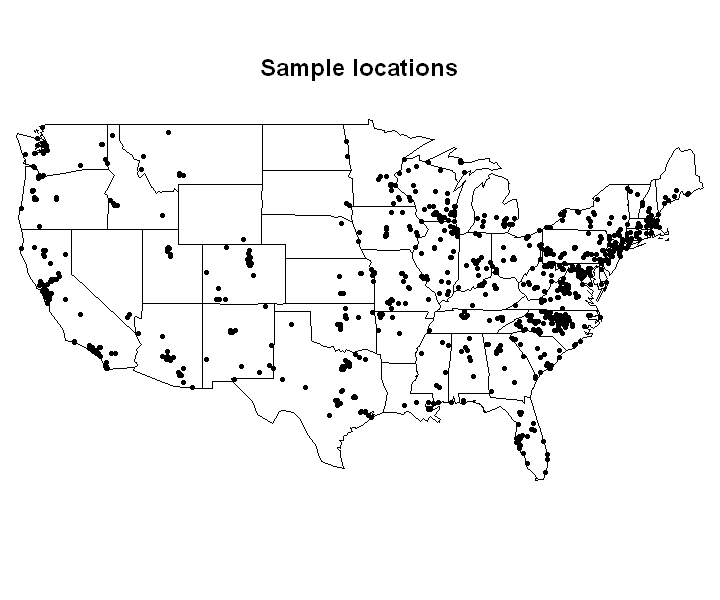

In [10]:
options(repr.plot.width=6, repr.plot.height=5)
map("state")
points(homes[,5],homes[,4],pch=19,cex=.5)
title("Sample locations")

### Features and labels individual analysis

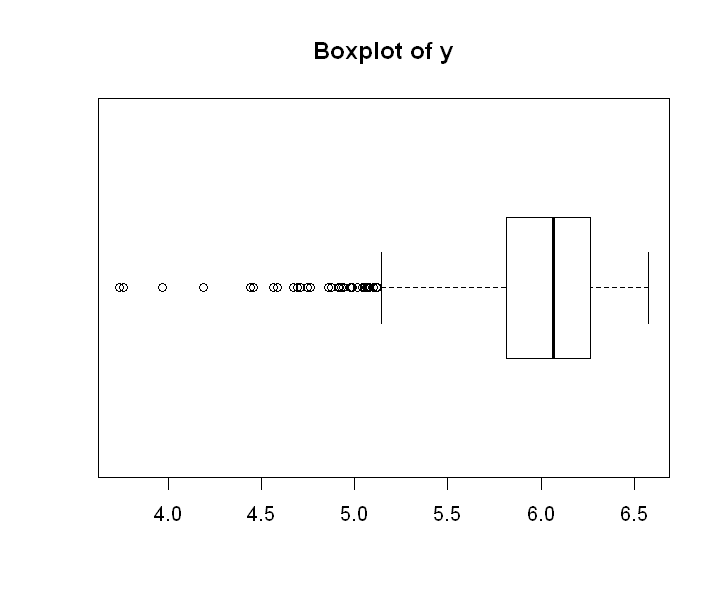

In [11]:
boxplot(y,horizontal=TRUE,main="Boxplot of y")

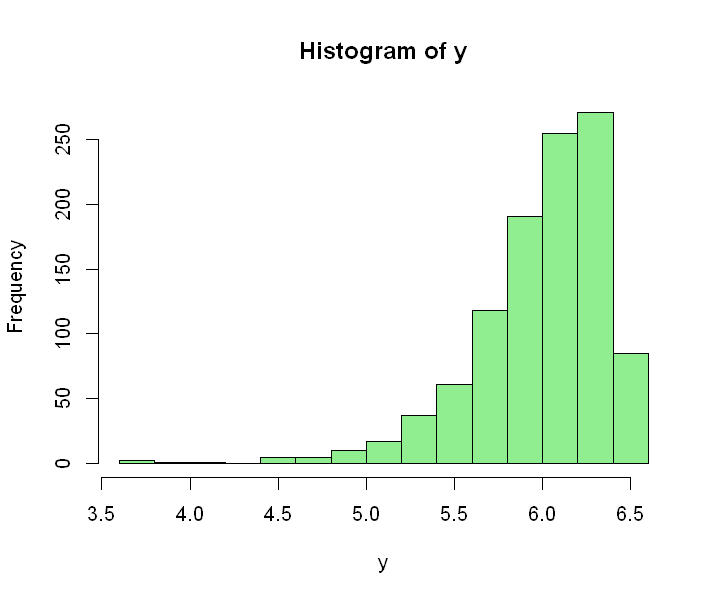

In [12]:
hist(y,col="LightGreen")

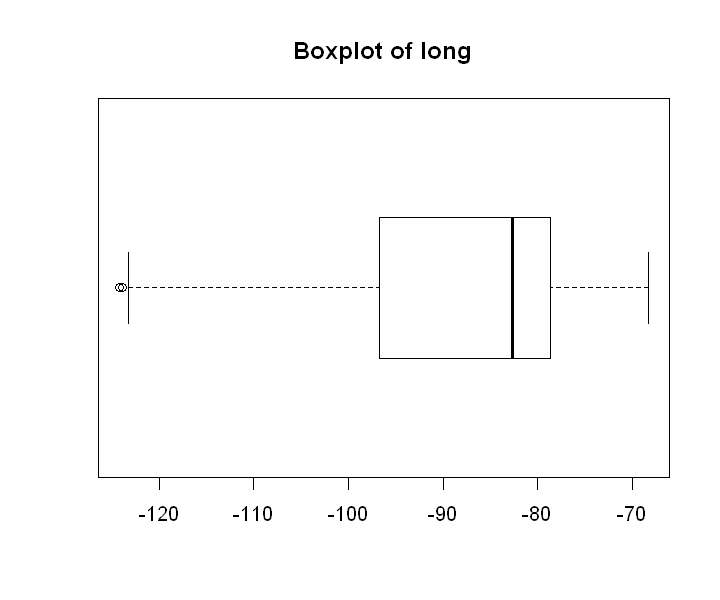

In [13]:
boxplot(long,horizontal=TRUE,main="Boxplot of long")

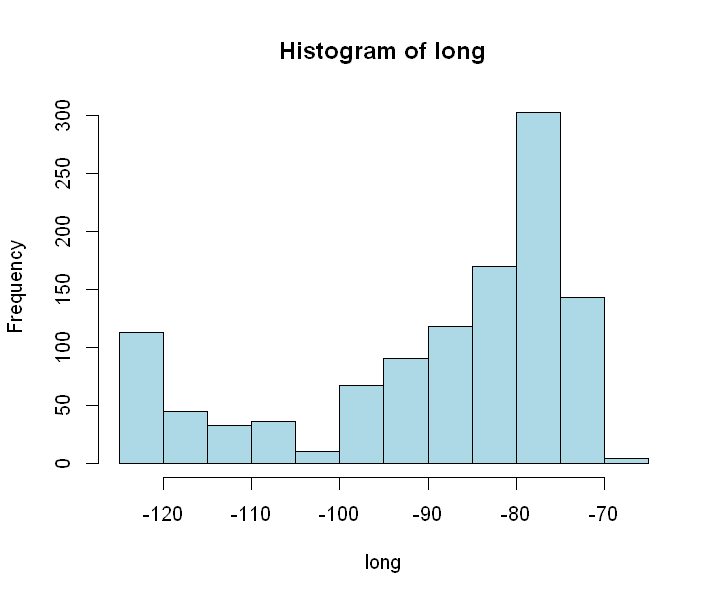

In [14]:
hist(long,col="LightBlue")

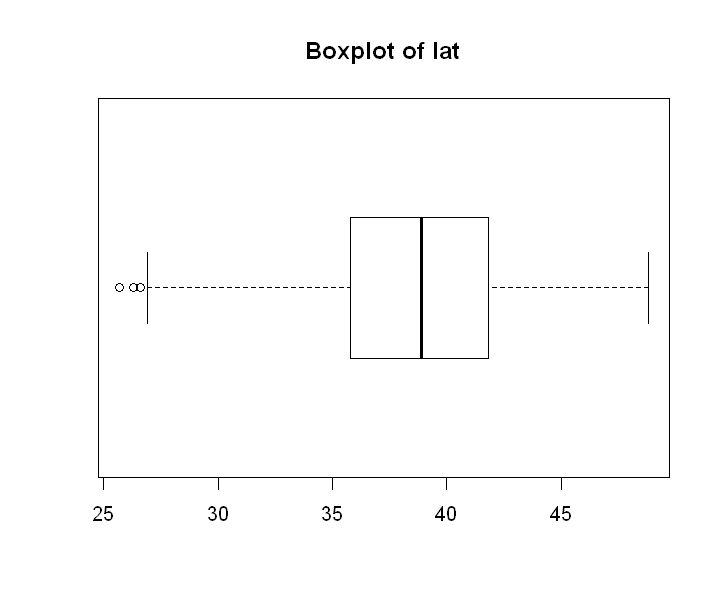

In [15]:
boxplot(lat,horizontal=TRUE,main="Boxplot of lat")

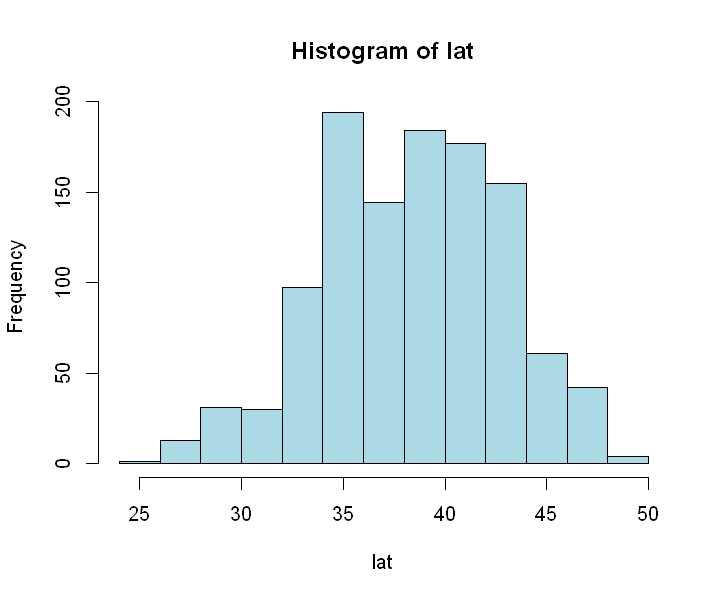

In [16]:
hist(lat,col="LightBlue")

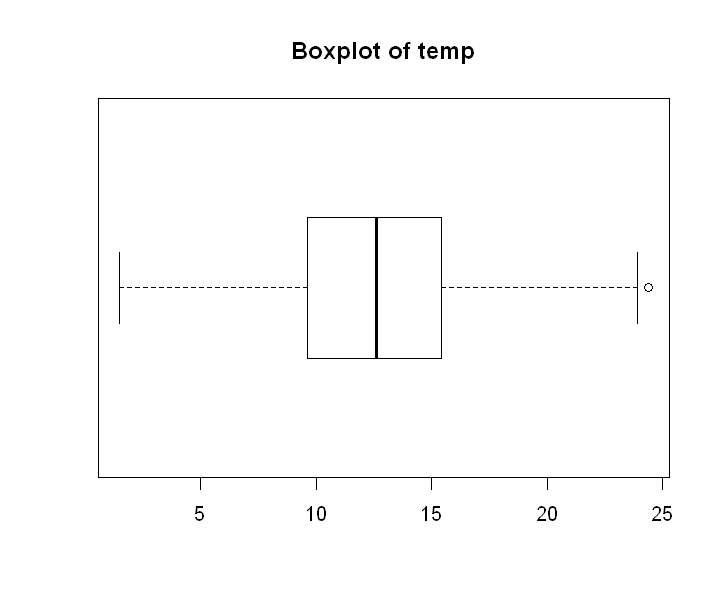

In [17]:
boxplot(temp,horizontal=TRUE,main="Boxplot of temp")

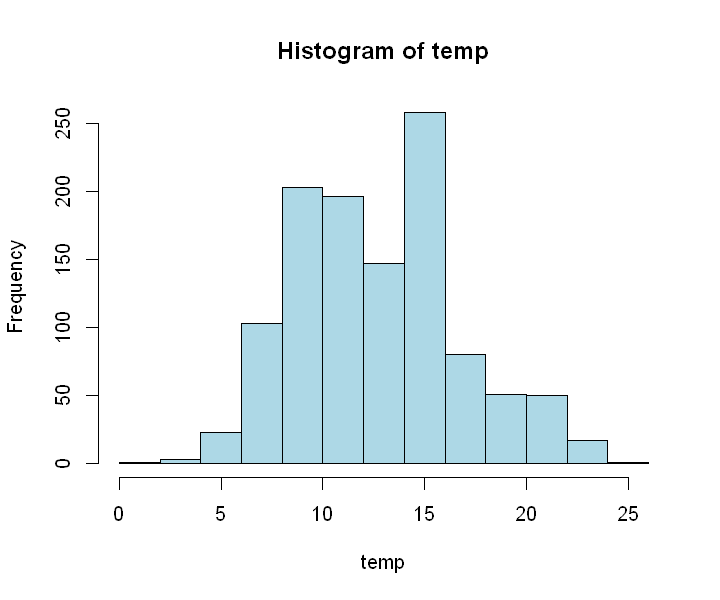

In [18]:
hist(temp,col="LightBlue")

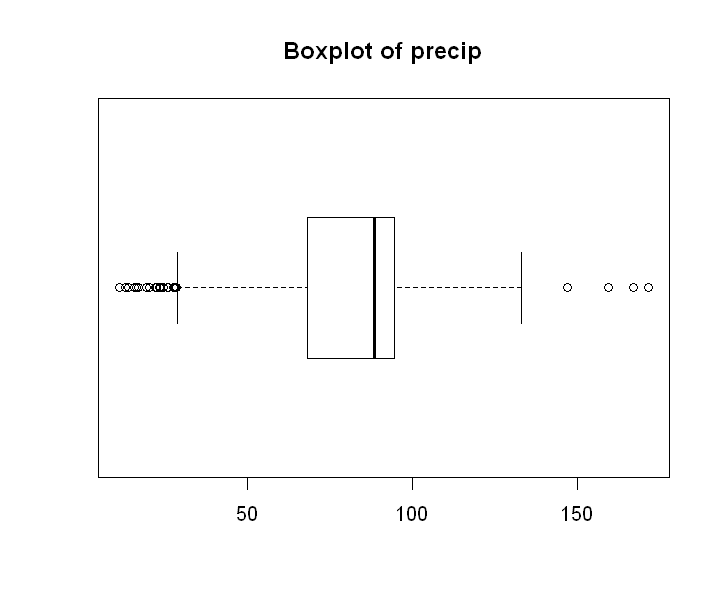

In [19]:
boxplot(precip,horizontal=TRUE,main="Boxplot of precip")

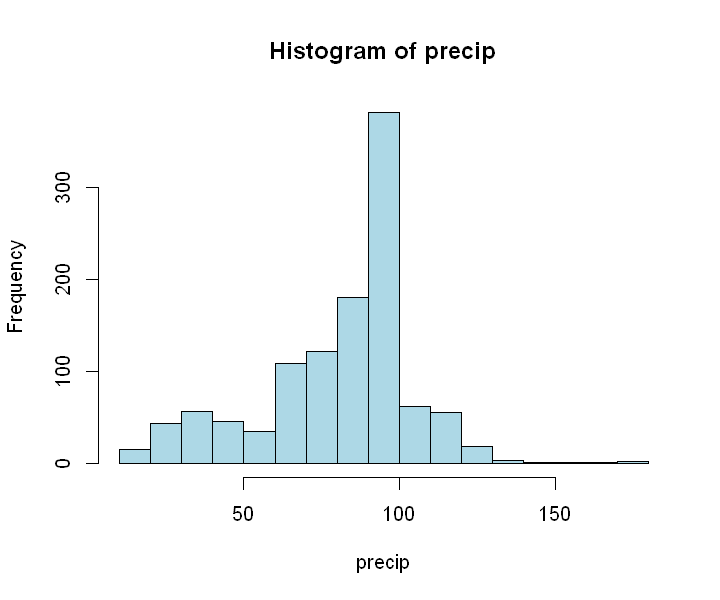

In [20]:
hist(precip,col="LightBlue")

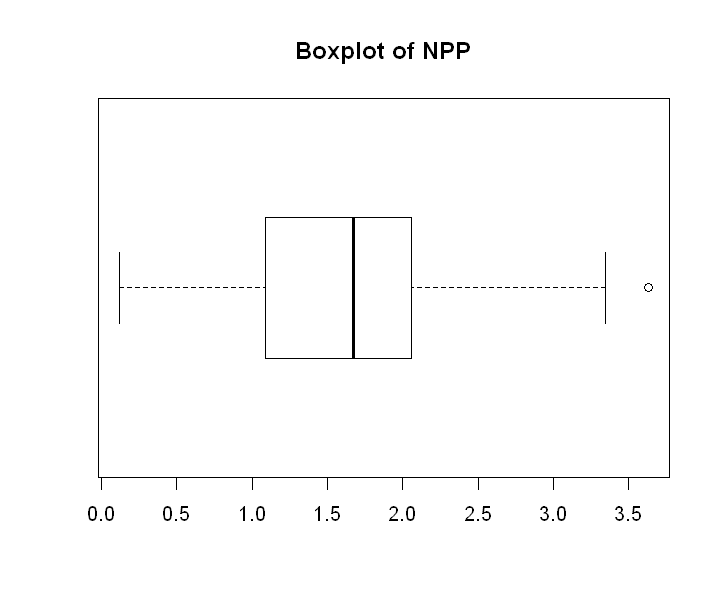

In [21]:
boxplot(NPP,horizontal=TRUE,main="Boxplot of NPP")

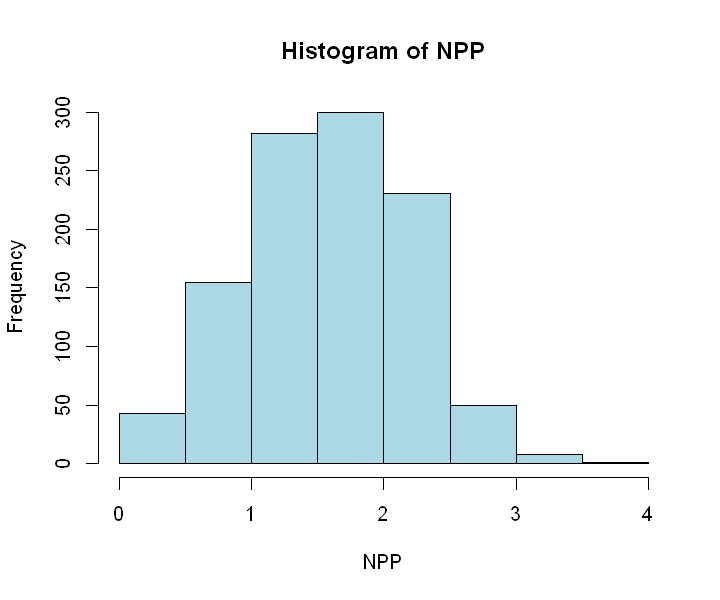

In [22]:
hist(NPP,col="LightBlue")

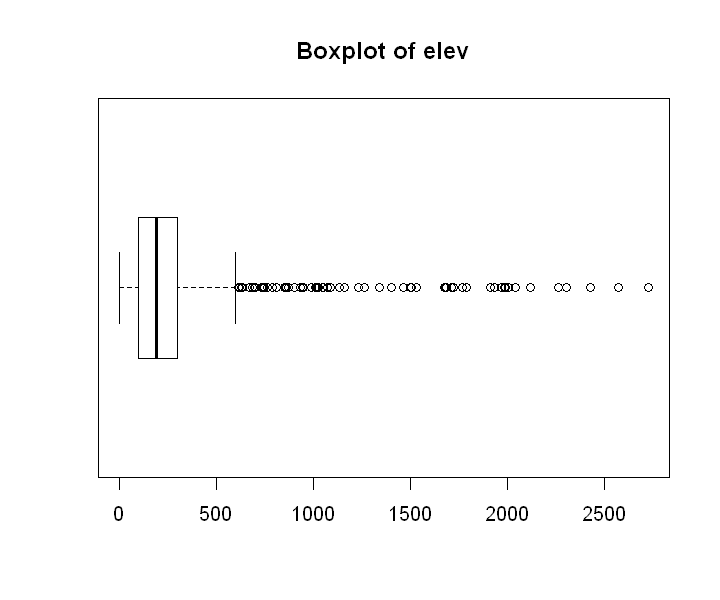

In [23]:
boxplot(elev,horizontal=TRUE,main="Boxplot of elev")

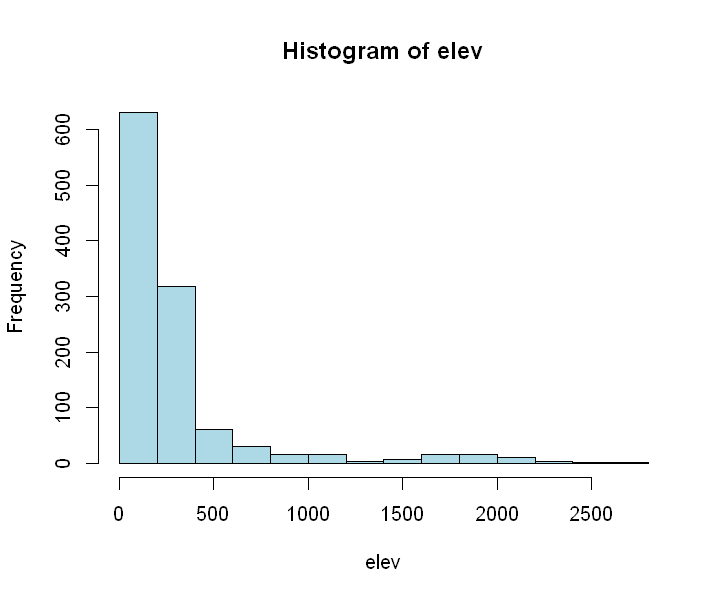

In [24]:
hist(elev,col="LightBlue")

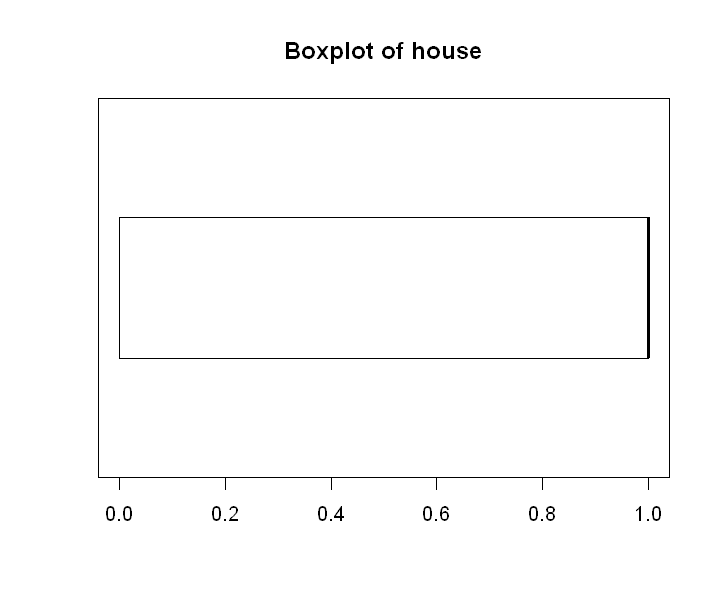

In [25]:
boxplot(house,horizontal=TRUE,main="Boxplot of house")

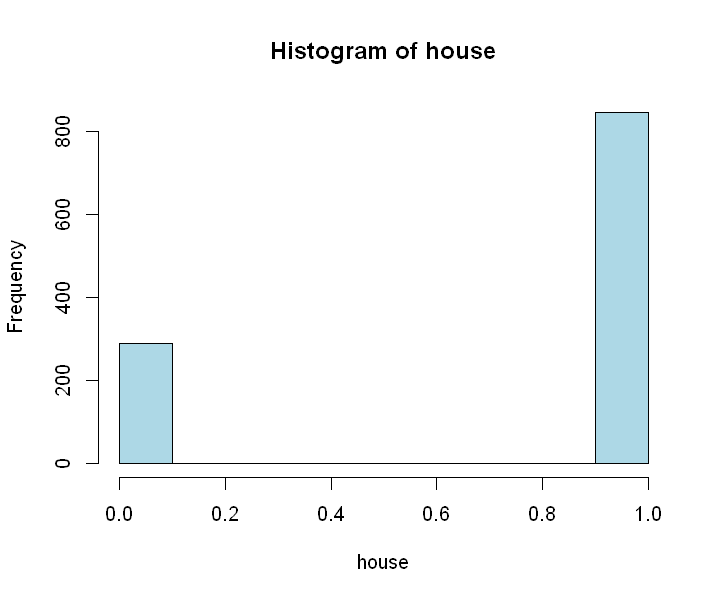

In [26]:
hist(house,col="LightBlue")

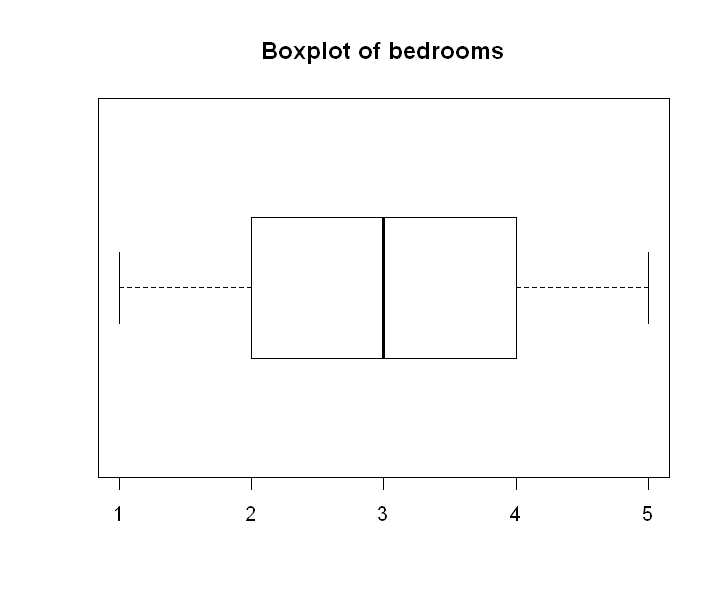

In [27]:
boxplot(bedrooms,horizontal=TRUE,main="Boxplot of bedrooms")

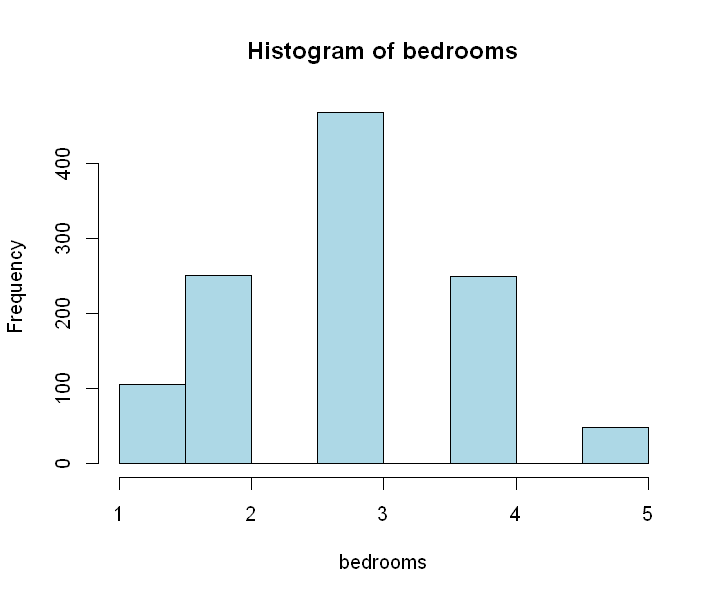

In [28]:
hist(bedrooms,col="LightBlue")

## Features correlations

In [29]:
# Overwrite the original "homes" data.frame
# For lm() we need a unique data.frame
# For glmnet() X and y
homes<-data.frame(cbind(y,X))
str(homes)

'data.frame':	1059 obs. of  9 variables:
 $ y       : num  6.01 6.37 6.24 6.38 6.32 ...
 $ long    : num  -1.392 0.615 -2.077 0.659 0.552 ...
 $ lat     : num  2.361 0.315 1.664 -0.104 -1.011 ...
 $ temp    : num  -1.9035 -0.6167 -0.5523 -0.0879 1.0303 ...
 $ precip  : num  -2.1978 0.4965 0.4455 -0.0762 0.7402 ...
 $ NPP     : num  -2.08 -0.194 0.586 0.912 0.449 ...
 $ elev    : num  1.775 0.37 -0.446 0.354 -0.459 ...
 $ house   : num  0.561 -1.779 -1.779 0.561 0.561 ...
 $ bedrooms: num  -0.9145 -0.9145 0.0964 0.0964 0.0964 ...


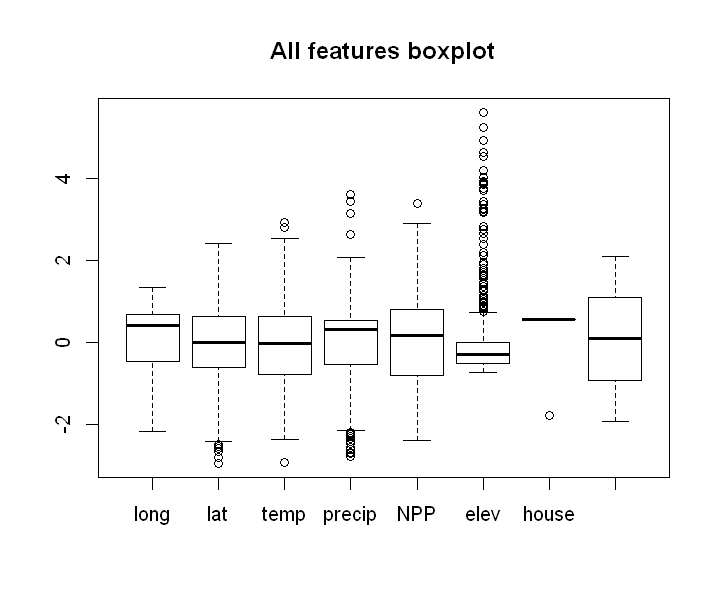

In [30]:
boxplot(X, main = "All features boxplot")

Is useful to see how features are correlated between them, and also how strong is the correlation between features and the labels

In [31]:
res <- cor(homes)
round(res, 2)

,y,long,lat,temp,precip,NPP,elev,house,bedrooms
y,1.00,0.14,0.18,-0.21,0.05,-0.02,-0.04,0.10,0.10
long,0.14,1.00,-0.10,-0.03,0.60,0.32,-0.35,0.00,0.02
lat,0.18,-0.10,1.00,-0.87,-0.14,-0.02,0.06,-0.06,-0.02
temp,-0.21,-0.03,-0.87,1.00,0.23,0.12,-0.36,0.04,0.01
precip,0.05,0.60,-0.14,0.23,1.00,0.66,-0.56,0.01,0.00
NPP,-0.02,0.32,-0.02,0.12,0.66,1.00,-0.44,-0.07,-0.06
elev,-0.04,-0.35,0.06,-0.36,-0.56,-0.44,1.00,0.07,0.02
house,0.10,0.00,-0.06,0.04,0.01,-0.07,0.07,1.00,0.53
bedrooms,0.10,0.02,-0.02,0.01,0.00,-0.06,0.02,0.53,1.00


corrplot 0.91 loaded


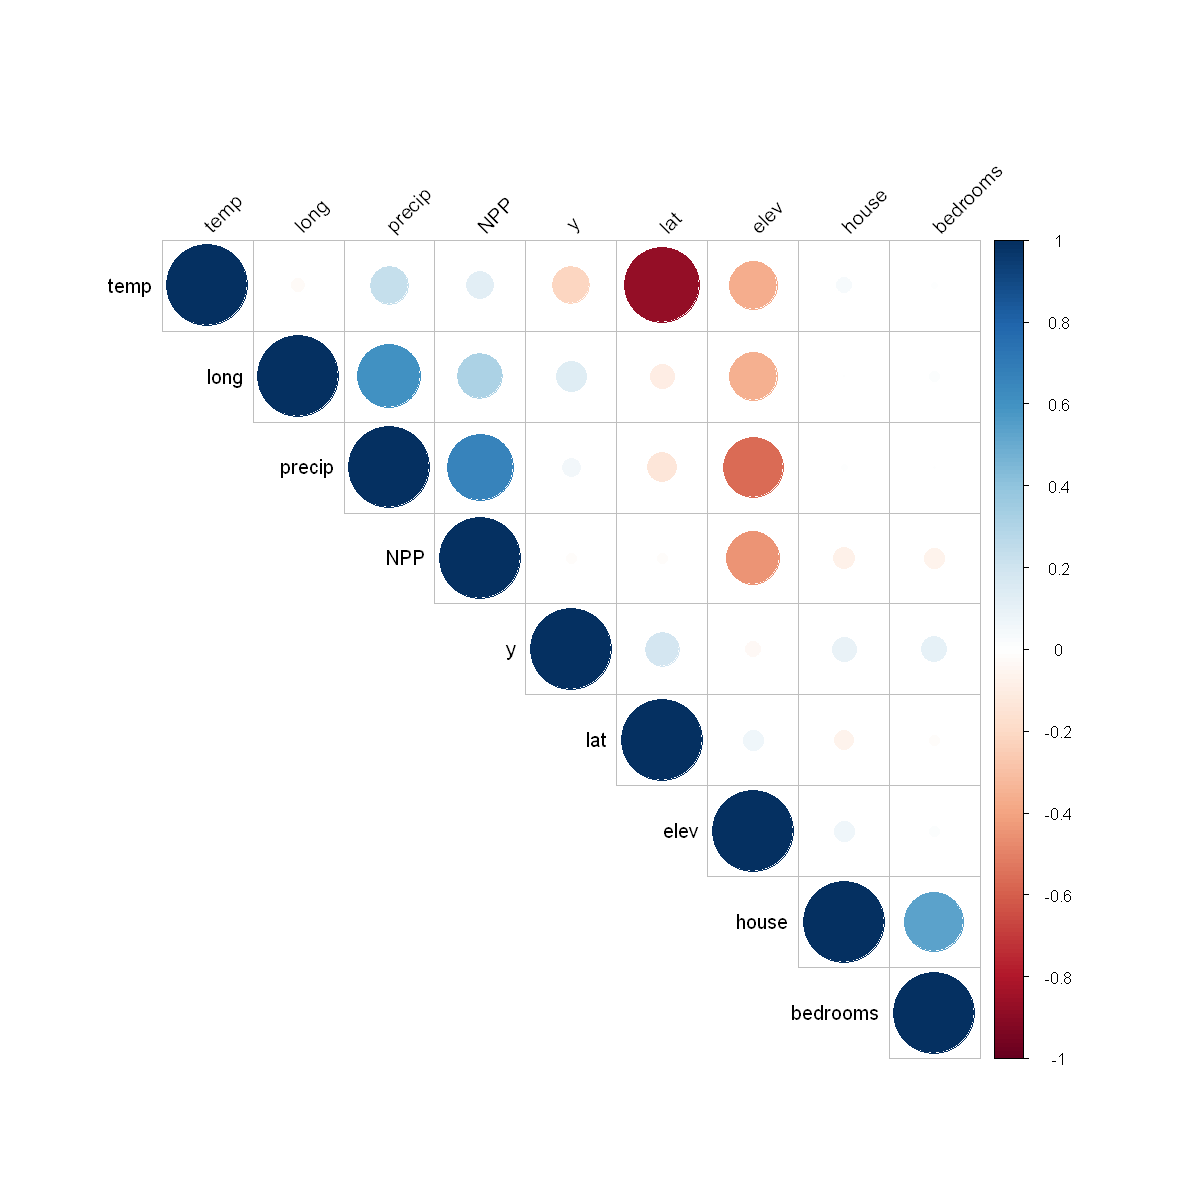

In [32]:
#install.packages("corrplot")
options(repr.plot.width=10, repr.plot.height=10)

library(corrplot)
corrplot(res, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45)

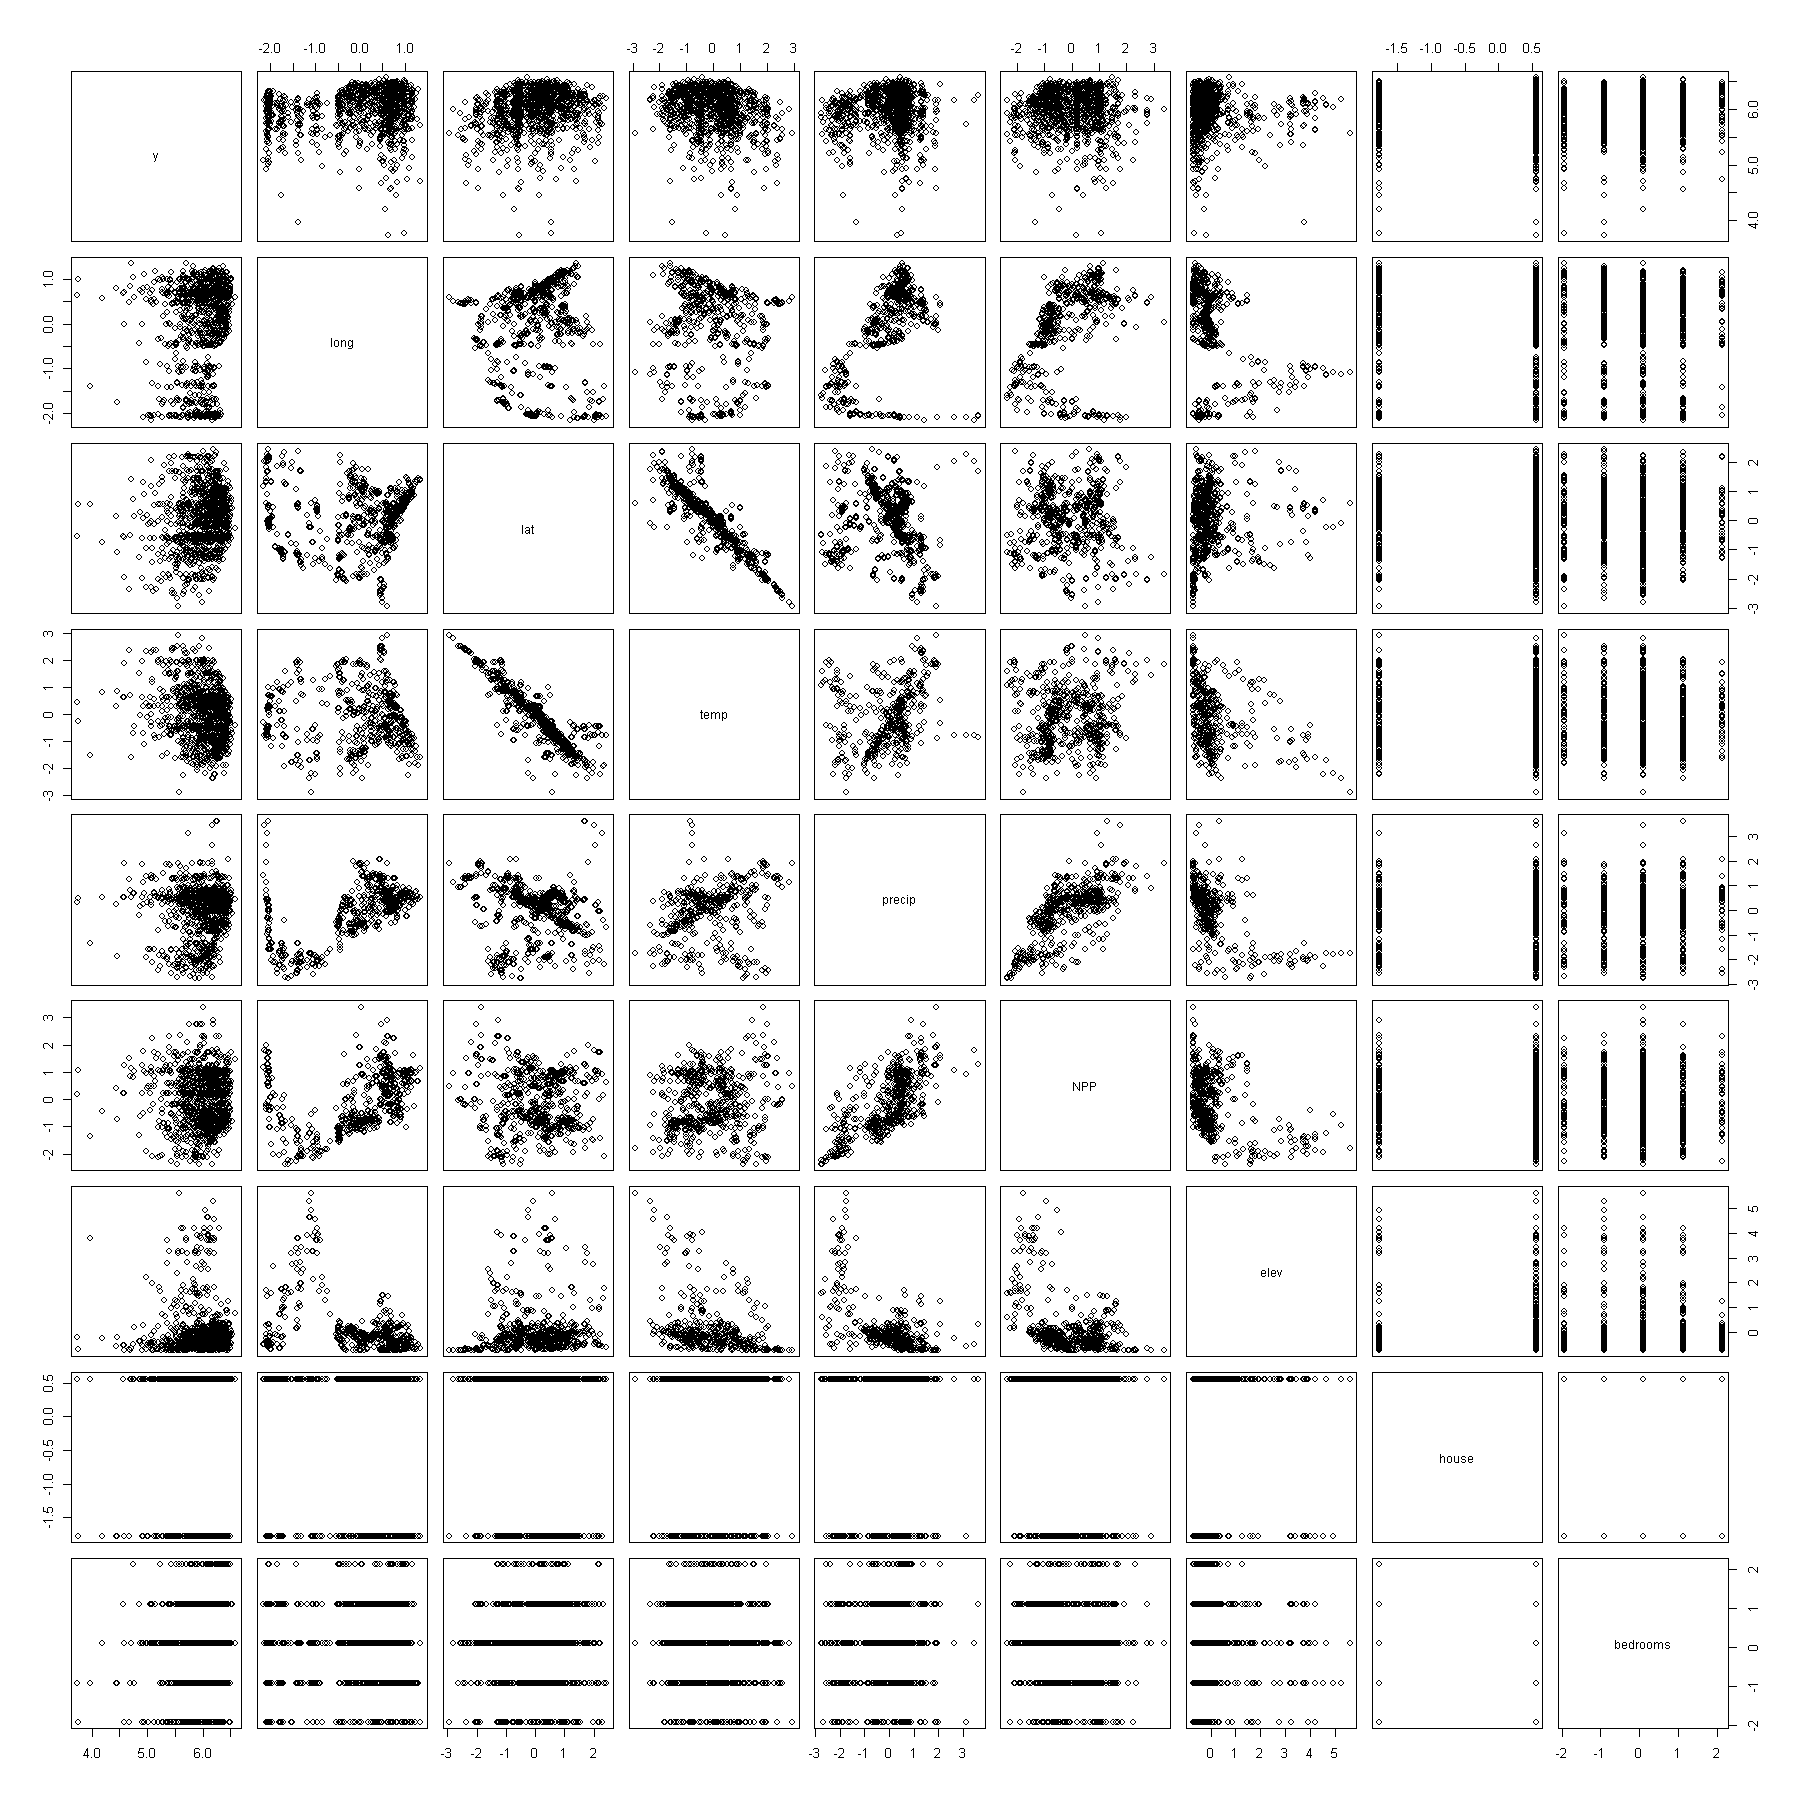

In [33]:
options(repr.plot.width=15, repr.plot.height=15)

pairs(y~.,data = homes)


If we take a look, we see that the features are not highly linearly correlated with y. The feature with the biggest correlation(absolut value) is temp, with -0.21.


**Is there multicollinearity?**

We see that some features are highly correlated between them, as lattitude and temperature (negative correlation) or with precipitations and NPP.

# OLS

In statistics, ordinary least squares (OLS) are a type of linear least squares method for estimating the unknown parameters in a linear regression model. OLS chooses the parameters of a linear function of a set of explanatory variables by the principle of least squares: minimizing the sum of the squares of the differences between the observed dependent variable (values of the variable being observed) in the given dataset and those predicted by the linear function of the independent variable.

https://en.wikipedia.org/wiki/Ordinary_least_squares

First, we will use OLS with all the features, and add combined features generated from the original ones.

In [34]:
homes.ols.01<-lm(y~.,data=homes)
summary(homes.ols.01)


Call:
lm(formula = y ~ ., data = homes)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.23684 -0.18011  0.08391  0.25095  0.60192 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.98998    0.01115 537.425  < 2e-16 ***
long         0.01741    0.01811   0.961 0.336800    
lat         -0.04991    0.03502  -1.425 0.154401    
temp        -0.14839    0.03841  -3.863 0.000119 ***
precip       0.02495    0.01959   1.274 0.203115    
NPP         -0.03663    0.01536  -2.384 0.017283 *  
elev        -0.06390    0.01968  -3.246 0.001206 ** 
house        0.02827    0.01329   2.126 0.033707 *  
bedrooms     0.02186    0.01321   1.655 0.098289 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3627 on 1050 degrees of freedom
Multiple R-squared:  0.08946,	Adjusted R-squared:  0.08252 
F-statistic: 12.89 on 8 and 1050 DF,  p-value: < 2.2e-16


In [35]:
anova(homes.ols.01)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
long,1,2.95727175,2.95727175,22.4791220,2.417003e-06
lat,1,5.83678208,5.83678208,44.3671558,4.383277e-11
temp,1,0.75911018,0.75911018,5.7702274,1.647278e-02
precip,1,0.03387244,0.03387244,0.2574747,6.119669e-01
NPP,1,0.73687628,0.73687628,5.6012207,1.812864e-02
elev,1,1.23216659,1.23216659,9.3660730,2.266523e-03
house,1,1.65461502,1.65461502,12.5772320,4.077032e-04
bedrooms,1,0.36019541,0.36019541,2.7379549,9.828896e-02
Residuals,1050,138.13419145,0.13155637,NA,NA


#### Summary of OLS with y ~ .

In [36]:
summary(homes.ols.01)


Call:
lm(formula = y ~ ., data = homes)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.23684 -0.18011  0.08391  0.25095  0.60192 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.98998    0.01115 537.425  < 2e-16 ***
long         0.01741    0.01811   0.961 0.336800    
lat         -0.04991    0.03502  -1.425 0.154401    
temp        -0.14839    0.03841  -3.863 0.000119 ***
precip       0.02495    0.01959   1.274 0.203115    
NPP         -0.03663    0.01536  -2.384 0.017283 *  
elev        -0.06390    0.01968  -3.246 0.001206 ** 
house        0.02827    0.01329   2.126 0.033707 *  
bedrooms     0.02186    0.01321   1.655 0.098289 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3627 on 1050 degrees of freedom
Multiple R-squared:  0.08946,	Adjusted R-squared:  0.08252 
F-statistic: 12.89 on 8 and 1050 DF,  p-value: < 2.2e-16


#### Variance Inflation Factor of OLS with y ~ .

In [37]:
round(vif(homes.ols.01),1)

long      lat     temp   precip      NPP     elev    house bedrooms 
     2.6      9.9     11.9      3.1      1.9      3.1      1.4      1.4

### Adding quadratic terms and second order interactions 

Now we just repeat the procedure of `homes.ols.01`, adding more terms to our model. 

Given a set of features, we can add up them and square them to easily obtain all the interactions between them using the build-in lm R function power.

Also can add the quadratic terms using I(feature^2)

#### Summary of OLS with y~(long+lat+temp+precip+NPP+elev+house+bedrooms)^2

In [38]:
homes.ols.02<-lm(y~(long+lat+temp+precip+NPP+elev+house+bedrooms)^2,data=homes)
summary(homes.ols.02)


Call:
lm(formula = y ~ (long + lat + temp + precip + NPP + elev + house + 
    bedrooms)^2, data = homes)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.31829 -0.16384  0.08208  0.24258  0.61198 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      6.1030275  0.0240496 253.768  < 2e-16 ***
long            -0.0098181  0.0306717  -0.320  0.74896    
lat             -0.0361580  0.0915811  -0.395  0.69306    
temp            -0.1167649  0.0872810  -1.338  0.18126    
precip          -0.0091370  0.0373634  -0.245  0.80686    
NPP             -0.0176187  0.0196964  -0.895  0.37126    
elev            -0.0222136  0.0576914  -0.385  0.70029    
house            0.0194459  0.0162203   1.199  0.23086    
bedrooms         0.0124930  0.0132470   0.943  0.34586    
long:lat         0.0654369  0.0571712   1.145  0.25265    
long:temp        0.0535385  0.0638085   0.839  0.40164    
long:precip     -0.0703916  0.0276315  -2.548  0.01100 *  
long:NP

#### Variance Inflation Factor of OLS with y~(long+lat+temp+precip+NPP+elev+house+bedrooms)^2

In [39]:
round(vif(homes.ols.02),1)

long             lat            temp          precip             NPP 
            7.8            69.6            63.2            11.6             3.2 
           elev           house        bedrooms        long:lat       long:temp 
           27.6             2.2             1.5            35.1            24.4 
    long:precip        long:NPP       long:elev      long:house   long:bedrooms 
            8.7             5.1            16.4             4.9             4.6 
       lat:temp      lat:precip         lat:NPP        lat:elev       lat:house 
            3.3            42.6            31.7             4.5            14.7 
   lat:bedrooms     temp:precip        temp:NPP       temp:elev      temp:house 
           13.6            76.0            43.5             7.3            17.0 
  temp:bedrooms      precip:NPP     precip:elev    precip:house precip:bedrooms 
           15.6             5.1            47.7             5.4             4.4 
       NPP:elev       NPP:house    NPP:bedrooms      elev:house   elev:bedrooms 
           23.7             2.9             2.6             4.7             4.2 
 house:bedrooms 
            1.7

#### Summary of OLS with y~long+lat+temp+precip+NPP+elev+house+bedrooms)^2+I(long^2)+I(lat^2)+I(temp^2)+I(precip^2)+I(NPP^2)+I(elev^2)+I(bedrooms^2)

In [40]:
homes.ols.03<-lm(y~(long+lat+temp+precip+NPP+elev+house+bedrooms)^2
                 +I(long^2)+I(lat^2)+I(temp^2)+I(precip^2)+I(NPP^2)+I(elev^2)
                 +I(bedrooms^2),data=homes)
summary(homes.ols.03)


Call:
lm(formula = y ~ (long + lat + temp + precip + NPP + elev + house + 
    bedrooms)^2 + I(long^2) + I(lat^2) + I(temp^2) + I(precip^2) + 
    I(NPP^2) + I(elev^2) + I(bedrooms^2), data = homes)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.27312 -0.16580  0.07882  0.23738  0.60122 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      6.1395485  0.0349957 175.437  < 2e-16 ***
long            -0.0697495  0.0446180  -1.563 0.118303    
lat             -0.0353436  0.0922012  -0.383 0.701555    
temp            -0.1446600  0.0884491  -1.636 0.102251    
precip           0.0116187  0.0400214   0.290 0.771638    
NPP             -0.0016541  0.0230038  -0.072 0.942691    
elev            -0.0551345  0.0638824  -0.863 0.388306    
house            0.0207129  0.0162811   1.272 0.203590    
bedrooms         0.0135995  0.0131941   1.031 0.302914    
I(long^2)       -0.0766234  0.0340346  -2.251 0.024577 *  
I(lat^2)         0.0130964  0.08

In [41]:
anova(homes.ols.03)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
long,1,2.957272e+00,2.957272e+00,2.353616e+01,1.418085e-06
lat,1,5.836782e+00,5.836782e+00,4.645343e+01,1.606763e-11
temp,1,7.591102e-01,7.591102e-01,6.041561e+00,1.413915e-02
precip,1,3.387244e-02,3.387244e-02,2.695820e-01,6.037255e-01
NPP,1,7.368763e-01,7.368763e-01,5.864607e+00,1.562270e-02
elev,1,1.232167e+00,1.232167e+00,9.806494e+00,1.788725e-03
house,1,1.654615e+00,1.654615e+00,1.316865e+01,2.988608e-04
bedrooms,1,3.601954e-01,3.601954e-01,2.866702e+00,9.073688e-02
I(long^2),1,1.634997e+00,1.634997e+00,1.301252e+01,3.244911e-04
I(lat^2),1,3.598204e+00,3.598204e+00,2.863717e+01,1.079030e-07


#### Variance Inflation Factor of OLS with y~long+lat+temp+precip+NPP+elev+house+bedrooms)^2+I(long^2)+I(lat^2)+I(temp^2)+I(precip^2)+I(NPP^2)+I(elev^2)+I(bedrooms^2)

In [42]:
round(vif(homes.ols.03),1)

long             lat            temp          precip             NPP 
           16.8            71.6            65.9            13.5             4.5 
           elev           house        bedrooms       I(long^2)        I(lat^2) 
           34.4             2.2             1.5            15.8           100.1 
      I(temp^2)     I(precip^2)        I(NPP^2)       I(elev^2)   I(bedrooms^2) 
          175.8             7.4             4.8           153.7             1.6 
       long:lat       long:temp     long:precip        long:NPP       long:elev 
           72.9            51.5            18.2             7.2            30.4 
     long:house   long:bedrooms        lat:temp      lat:precip         lat:NPP 
            4.9             4.7           410.7            65.6            43.9 
       lat:elev       lat:house    lat:bedrooms     temp:precip        temp:NPP 
           51.5            14.8            13.6            99.1            58.8 
      temp:elev      temp:house   temp:bedrooms      precip:NPP     precip:elev 
          213.4            17.1            15.7            16.3            55.9 
   precip:house precip:bedrooms        NPP:elev       NPP:house    NPP:bedrooms 
            5.5             4.5            28.6             2.9             2.6 
     elev:house   elev:bedrooms  house:bedrooms 
            4.8             4.2             2.5

## Stepwise selection of predictors

Now, given a set of features, we have to select the best ones for our model. However, to do that we have to compute $2^n$ combinations of models. That is computationally unachievable for our set of features. That is why we use stepwise selection, which in each step selects the better features. We can do that using the `step()` function. That function is really powerful and allows us to do both forward and backwards selection. 

##### Forward selection

With forward selection we start with an empty model and the we add step by step the best features.

In [43]:
# Null model (with only intercept)
ls0<-lm(y~1, data=homes)
summary(ls0)


Call:
lm(formula = y ~ 1, data = homes)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.25232 -0.17585  0.07612  0.27436  0.58648 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.98998    0.01164   514.8   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3787 on 1058 degrees of freedom


In [44]:
# Select from homes.ols.03 features
homes.ols.forward = step(ls0,'~(long+lat+temp+precip+NPP+elev+house+bedrooms)^2+I(long^2)+I(lat^2)+I(temp^2)+I(precip^2)+I(NPP^2)+I(elev^2)+I(bedrooms^2)')

Start:  AIC=-2055.79
y ~ 1

                Df Sum of Sq    RSS     AIC
+ temp           1    6.6988 145.01 -2101.6
+ I(lat^2)       1    5.6782 146.03 -2094.2
+ lat            1    5.0143 146.69 -2089.4
+ I(precip^2)    1    4.2878 147.42 -2084.2
+ I(temp^2)      1    3.7035 148.00 -2080.0
+ I(long^2)      1    3.1670 148.54 -2076.1
+ long           1    2.9573 148.75 -2074.6
+ I(NPP^2)       1    2.3027 149.40 -2070.0
+ bedrooms       1    1.5496 150.16 -2064.7
+ house          1    1.3730 150.33 -2063.4
+ I(bedrooms^2)  1    0.8974 150.81 -2060.1
+ I(elev^2)      1    0.6914 151.01 -2058.6
+ precip         1    0.4135 151.29 -2056.7
<none>                       151.71 -2055.8
+ elev           1    0.2300 151.47 -2055.4
+ NPP            1    0.0474 151.66 -2054.1

Step:  AIC=-2101.61
y ~ temp

                Df Sum of Sq    RSS     AIC
+ I(long^2)      1    4.1271 140.88 -2130.2
+ I(lat^2)       1    3.5309 141.47 -2125.7
+ I(precip^2)    1    3.2028 141.80 -2123.3
+ I(elev^2)      

#### Summary of the ols forward selection model

In [45]:
summary(homes.ols.forward)


Call:
lm(formula = y ~ temp + I(long^2) + house + elev + long + I(lat^2) + 
    I(bedrooms^2) + precip + temp:house, data = homes)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.27687 -0.16751  0.08198  0.24444  0.58225 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    6.141898   0.023464 261.758  < 2e-16 ***
temp          -0.117101   0.013058  -8.968  < 2e-16 ***
I(long^2)     -0.084315   0.015460  -5.454 6.15e-08 ***
house          0.028975   0.011425   2.536  0.01135 *  
elev          -0.075920   0.014968  -5.072 4.65e-07 ***
long          -0.098944   0.024723  -4.002 6.72e-05 ***
I(lat^2)      -0.051137   0.009197  -5.560 3.42e-08 ***
I(bedrooms^2) -0.017746   0.008797  -2.017  0.04391 *  
precip         0.030241   0.016379   1.846  0.06512 .  
temp:house     0.030932   0.011648   2.656  0.00804 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3543 on 1049 degrees of freedom
Multip

#### Variance Inflation Factor of OLS with forward selection

In [46]:
round(vif(homes.ols.forward),1)

temp     I(long^2)         house          elev          long 
          1.4           3.3           1.1           1.9           5.2 
     I(lat^2) I(bedrooms^2)        precip    temp:house 
          1.3           1.1           2.3           1.0

The resultant model for forward selection is: **y ~ temp + I(long^2) + house + elev + long + I(lat^2) + I(bedrooms^2) + precip + temp:house**

##### Backwards selection

We also can do the opposite procedure and start with a model with all the features, and step by step remove the bad ones. This may be computationally slower, and for some models with a lot of features it would not be very recommendable.

In [47]:
# Start with the model homes.ols.03
homes.ols.backwards = step(homes.ols.03)

Start:  AIC=-2153.59
y ~ (long + lat + temp + precip + NPP + elev + house + bedrooms)^2 + 
    I(long^2) + I(lat^2) + I(temp^2) + I(precip^2) + I(NPP^2) + 
    I(elev^2) + I(bedrooms^2)

                  Df Sum of Sq    RSS     AIC
- house:bedrooms   1   0.00012 127.53 -2155.6
- lat:elev         1   0.00012 127.53 -2155.6
- NPP:house        1   0.00096 127.53 -2155.6
- long:temp        1   0.00132 127.53 -2155.6
- I(lat^2)         1   0.00323 127.54 -2155.6
- temp:elev        1   0.00616 127.54 -2155.5
- long:lat         1   0.00714 127.54 -2155.5
- long:house       1   0.01293 127.55 -2155.5
- long:bedrooms    1   0.01456 127.55 -2155.5
- elev:house       1   0.01867 127.55 -2155.4
- elev:bedrooms    1   0.02018 127.55 -2155.4
- I(temp^2)        1   0.02032 127.55 -2155.4
- lat:house        1   0.02938 127.56 -2155.3
- long:elev        1   0.03501 127.57 -2155.3
- NPP:elev         1   0.03731 127.57 -2155.3
- precip:house     1   0.03814 127.57 -2155.3
- lat:temp         1   0.04404 

#### Summary of the ols backwards selection model

In [48]:
summary(homes.ols.backwards)


Call:
lm(formula = y ~ long + lat + temp + precip + NPP + elev + house + 
    bedrooms + I(long^2) + I(precip^2) + I(NPP^2) + I(bedrooms^2) + 
    long:NPP + lat:temp + temp:precip + temp:NPP + temp:house + 
    temp:bedrooms + precip:NPP + NPP:bedrooms, data = homes)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.27040 -0.16470  0.08273  0.24125  0.63967 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    6.139748   0.031255 196.441  < 2e-16 ***
long          -0.079986   0.030751  -2.601 0.009426 ** 
lat            0.028438   0.039320   0.723 0.469692    
temp          -0.091292   0.041861  -2.181 0.029420 *  
precip         0.032484   0.022671   1.433 0.152201    
NPP           -0.001615   0.020249  -0.080 0.936430    
elev          -0.047784   0.027261  -1.753 0.079927 .  
house          0.021307   0.013585   1.568 0.117096    
bedrooms       0.014119   0.012996   1.086 0.277549    
I(long^2)     -0.102469   0.021232  -4.826  1.6e-06

#### Variance Inflation Factor of OLS with backwards selection

In [49]:
round(vif(homes.ols.backwards),1)

long           lat          temp        precip           NPP 
          8.1          13.2          15.0           4.4           3.5 
         elev         house      bedrooms     I(long^2)   I(precip^2) 
          6.3           1.6           1.4           6.2           5.1 
     I(NPP^2) I(bedrooms^2)      long:NPP      lat:temp   temp:precip 
          4.4           1.1           3.1           2.0           5.8 
     temp:NPP    temp:house temp:bedrooms    precip:NPP  NPP:bedrooms 
          4.2           1.5           1.5          12.2           1.0

The resultant model for forward selection is: 

**y ~ long + lat + temp + precip + NPP + elev + house + 
    bedrooms + I(long^2) + I(precip^2) + I(NPP^2) + I(bedrooms^2) + 
    long:NPP + lat:temp + temp:precip + temp:NPP + temp:house + 
    temp:bedrooms + precip:NPP + NPP:bedrooms**

osl.mod<-glmnet(X[train,],y[train],alpha=0,lambda=0, thresh=1e-12)
osl.pred<-predict(osl.mod, newx=X[test,])
round(mean((osl.pred-y.test)^2),20)

## Split train and test

In [50]:
#install.packages("rsample",dependencies=TRUE,repos= "https://cloud.r-project.org")
#install.packages("glmnet",dependencies=TRUE,repos= "https://cloud.r-project.org")
#install.packages("dplyr",dependencies=TRUE,repos= "https://cloud.r-project.org")
#install.packages("ggplot2",dependencies=TRUE,repos= "https://cloud.r-project.org")
#install.packages("MASS",dependencies=TRUE,repos= "https://cloud.r-project.org")
#install.packages("broom",dependencies=TRUE,repos= "https://cloud.r-project.org")

In [51]:
library(rsample)  # data splitting 
library(glmnet)   # implementing regularized regression approaches
library(dplyr)    # basic data manipulation procedures
library(ggplot2)
require(MASS)
require(broom)

Warning message:
"package 'glmnet' was built under R version 3.6.3"Loading required package: Matrix
Warning message:
"package 'Matrix' was built under R version 3.6.3"Loaded glmnet 4.1-1
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following object is masked from 'package:car':

    recode

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
"non-uniform 'Rounding' sampler used"Loading required package: MASS
Warning message:
"package 'MASS' was built under R version 3.6.3"
Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: broom


To test our model first we need to split the dataset into train and set.

In [52]:
set.seed(1)
homes_split <- initial_split(homes, prop = .7)
homes_train <- training(homes_split)
homes_test  <- testing(homes_split)

set.seed(1)
train_ix<-sample(1:nrow(X), nrow(X)/2)
test_ix<-(-train_ix)
y.test_ix<-y[test_ix]

Now we just define the model data, and the model formula, which is the same as in `homes.ols.04`

In [53]:
homes_train_x <- model.matrix(y ~ long + lat + temp + precip + NPP + elev + house + bedrooms 
                 + I(long^2) + I(precip^2) + I(NPP^2) + I(bedrooms^2) 
                 + long:NPP + lat:temp + temp:precip + temp:NPP + temp:house
                 + temp:bedrooms + precip:NPP + NPP:bedrooms, homes_train)[, -1]

homes_train_y <- homes_train$y

homes_test_x <- model.matrix(y ~ long + lat + temp + precip + NPP + elev + house + bedrooms 
                 + I(long^2) + I(precip^2) + I(NPP^2) + I(bedrooms^2) 
                 + long:NPP + lat:temp + temp:precip + temp:NPP + temp:house
                 + temp:bedrooms + precip:NPP + NPP:bedrooms, homes_test)[, -1]

homes_test_y <- homes_test$y

homes_df = data.frame(cbind(homes_train_y, homes_train_x))

## Ridge Regressor

![ridge](https://images.deepai.org/glossary-terms/d154adc4d9cd44849c10592a521f379d/ridge.png)

First, we use the `lm. Ridge` function to visualize how does the coefficient values change, depending on the lambda value. This value penalizes our minimization function to encourage the coefficients to be smaller. That is why while the lambda gets higher, we see that the coefficients get near 0.

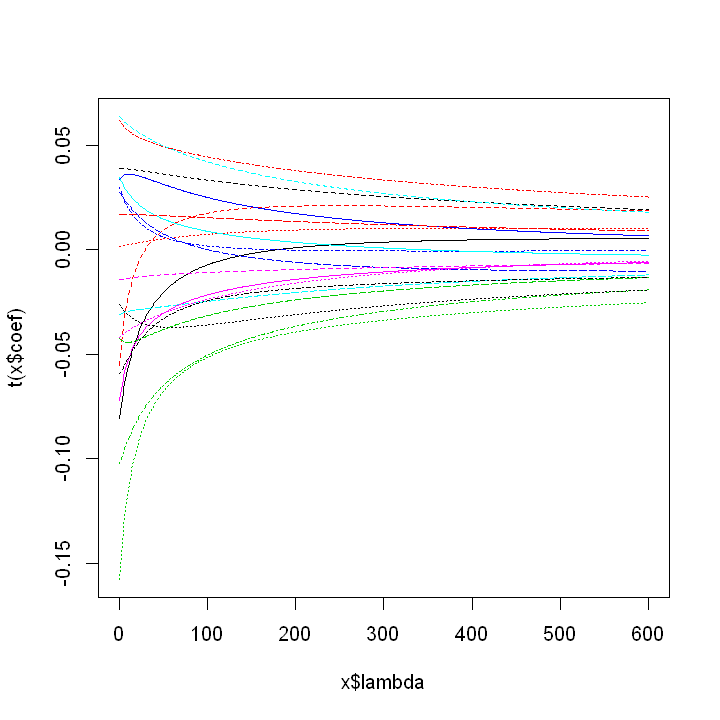

In [54]:
homes.ridge.01 <- lm.ridge(formula = y ~ long + lat + temp + precip + NPP + elev + house + bedrooms 
                 + I(long^2) + I(precip^2) + I(NPP^2) + I(bedrooms^2) 
                 + long:NPP + lat:temp + temp:precip + temp:NPP + temp:house
                 + temp:bedrooms + precip:NPP + NPP:bedrooms, data = homes, lambda=seq(0,600,by=1), subset=train_ix)

options(repr.plot.width=6, repr.plot.height=6)
plot(homes.ridge.01, xvar = "lambda")


We can use the glmnet library to easily plot how does the mean squared error between our train set change depending on the value of lambda, using cross validation `cv.glmnet`.

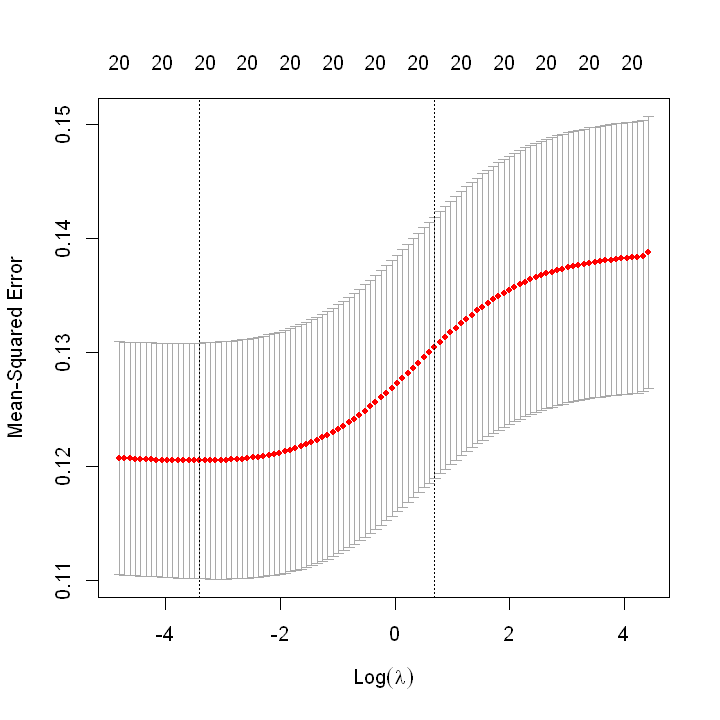

In [55]:
set.seed(1)
options(repr.plot.width=6, repr.plot.height=6)
cv.out<-cv.glmnet(homes_train_x,homes_train_y,alpha=0, nfolds=100)
plot(cv.out)

Here we can see which is the best lambda value

[1] 0.03331

[1] -3.40177

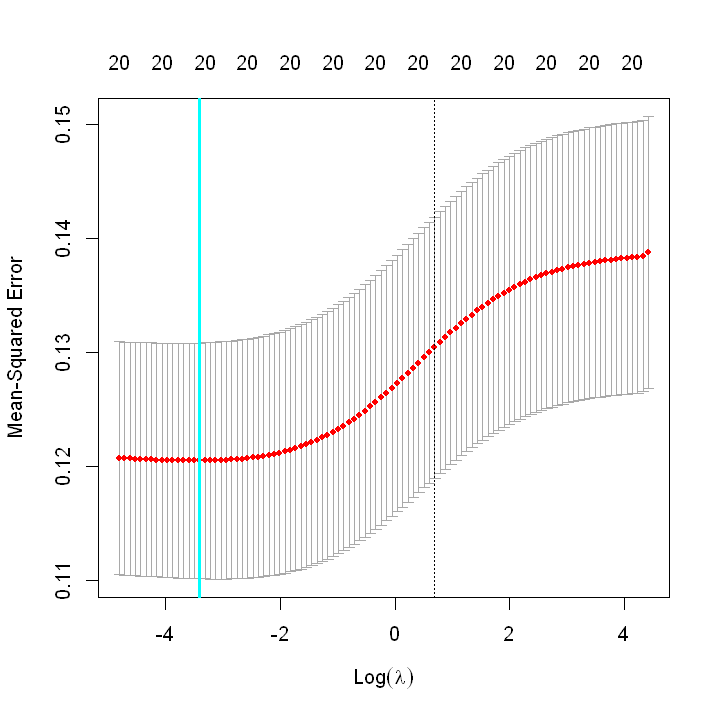

In [56]:
options(repr.plot.width=6, repr.plot.height=6)
bestlam<-cv.out$lambda.min
round(bestlam,5)
round(log(bestlam),5)
plot(cv.out)
abline(v=log(bestlam),lwd=3,col="cyan")

With the following plot we can visually see which coefficients have higher absolute values, and those which are around 0. When a feature has a high coefficient absolute value, it means that it is really important for the model, and when it is around 0 the ridge regressor is practically not making use of it.

Warning message:
"'tidy.dgCMatrix' is deprecated.
See help("Deprecated")"Warning message:
"'tidy.dgTMatrix' is deprecated.
See help("Deprecated")"

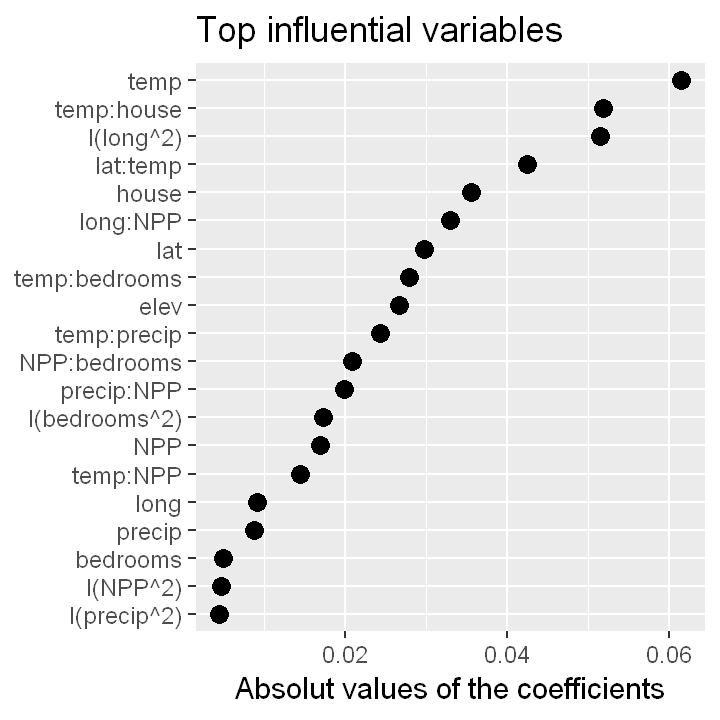

In [57]:
ridge.mod<-glmnet(homes_train_x, homes_train_y, lambda=bestlam, alpha=0, thresh=1e-12)

options(repr.plot.width=6, repr.plot.height=6)
theme_set(theme_gray(base_size = 18))
abs(coef(ridge.mod, s = "lambda.1se")) %>%
  tidy() %>%
  filter(row != "(Intercept)") %>%
  top_n(20, wt = abs(value)) %>%
  ggplot(aes(value, reorder(row, value))) +
  geom_point(size=5) +
  ggtitle("Top influential variables") +
  xlab("Absolut values of the coefficients") +
  ylab(NULL)

In [58]:
coef(ridge.mod)

21 x 1 sparse Matrix of class "dgCMatrix"
                        s0
(Intercept)    6.113103306
long          -0.009176436
lat            0.029792218
temp          -0.061480931
precip         0.008815047
NPP           -0.016885303
elev          -0.026626102
house          0.035507157
bedrooms       0.004921548
I(long^2)     -0.051480600
I(precip^2)    0.004491327
I(NPP^2)       0.004687297
I(bedrooms^2) -0.017364037
long:NPP      -0.032909533
lat:temp       0.042411462
temp:precip   -0.024286693
temp:NPP       0.014430903
temp:house     0.051865067
temp:bedrooms -0.027905539
precip:NPP    -0.019863241
NPP:bedrooms   0.020940919

### Models comparison

Now, using the train and test splits we can compare the two models and the mean squared error for each one.

In [59]:
#Ridge regressor
ridge.mod<-glmnet(homes_train_x, homes_train_y, lambda=bestlam, alpha=0, thresh=1e-12)
ridge.pred<-predict(ridge.mod, newx=homes_test_x)
round(mean((ridge.pred-homes_test_y)^2),20)

[1] 0.1459025

In [60]:
#Linear regressor
ols.mod<-glmnet(homes_train_x, homes_train_y, lambda=0, alpha=0, thresh=1e-12)
osl.pred<-predict(ols.mod,x=homes_train_x,y=homes_train_y,s=0,newx=homes_test_x,exact=TRUE)
round(mean((osl.pred-homes_test_y)^2),200)


[1] 0.1450428

We see that the simple OLS model performs better in this case. As we have seen on the plots, the lambda values around 0 gave the better scores. However, this may be caused by the particular way we chose the data. A significant lambda value could help us to avoid overfitting.

## LASSO

![lasso](https://rstatisticsblog.com/wp-content/uploads/2020/05/lasso.jpg)

We will use `glmenet` to visualize how the coefficients change with lasso

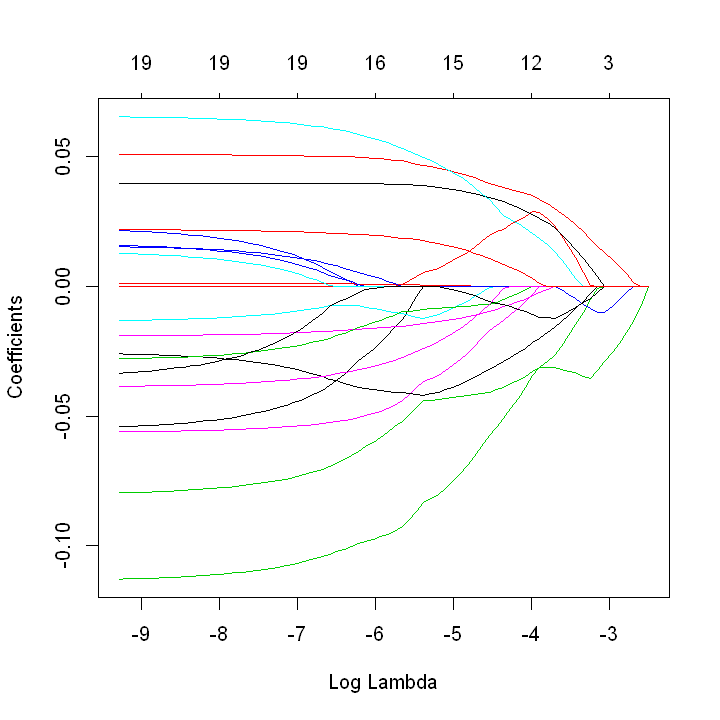

In [61]:
## Apply lasso regression to ames data
homes_lasso <- glmnet(
  x = homes_train_x,
  y = homes_train_y,
  alpha = 1
)

plot(homes_lasso, xvar = "lambda")

`glmnet` function uses ridge when the value alpha is set to 0, and lasso when it is set to one. Now we should do the same as with the ridge regressor, but using lasso.

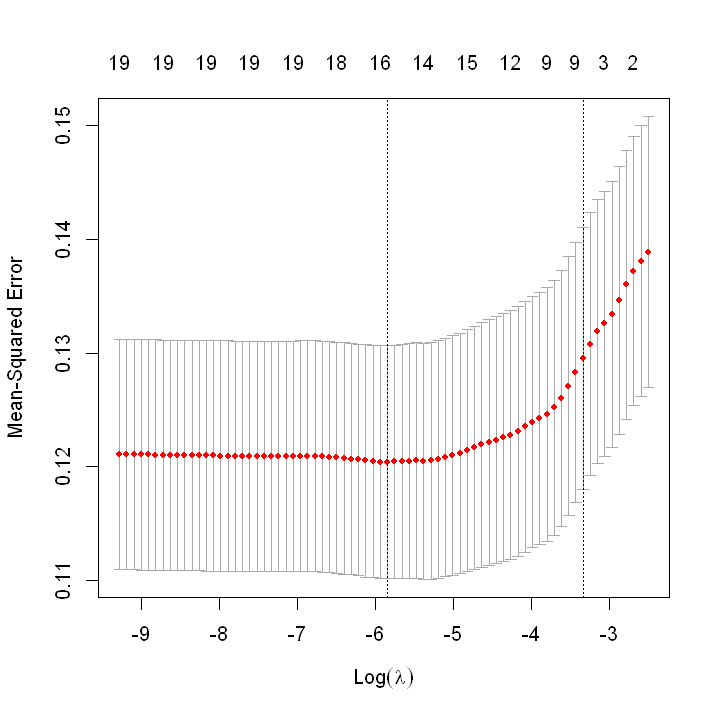

In [62]:
set.seed(1)
cv.out<-cv.glmnet(homes_train_x,homes_train_y, alpha=1, nfolds=100)
plot(cv.out)

We can also plot the best lambda value.

[1] 0.0029

[1] -5.8439

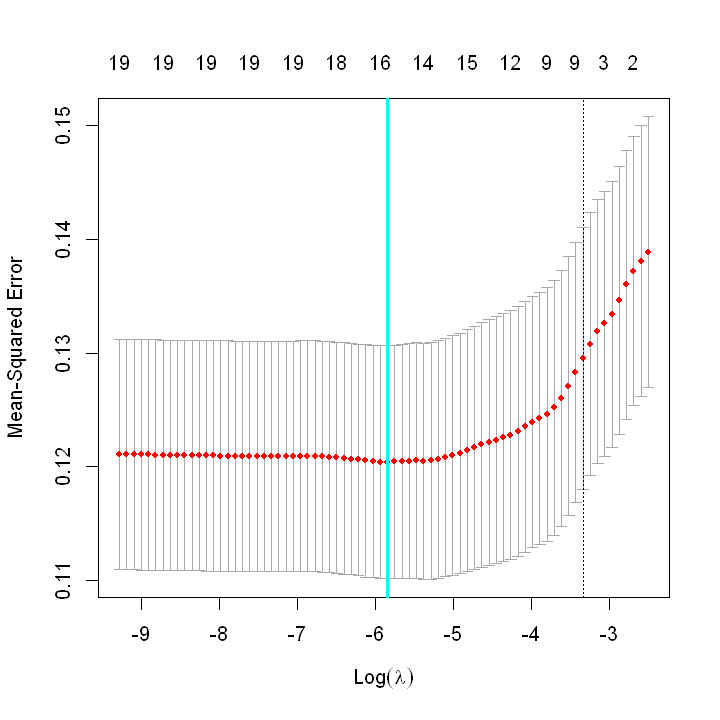

In [63]:
bestlam<-cv.out$lambda.min
round(bestlam,5)
round(log(bestlam),5)
plot(cv.out)
abline(v=log(bestlam),lwd=3,col="cyan")

If we plot the top influential variables, we see that the lasso model, when the lambda is increased, tends to 'cut' the coefficients to zero of the less valuable features for our model. 

Warning message:
"'tidy.dgCMatrix' is deprecated.
See help("Deprecated")"Warning message:
"'tidy.dgTMatrix' is deprecated.
See help("Deprecated")"

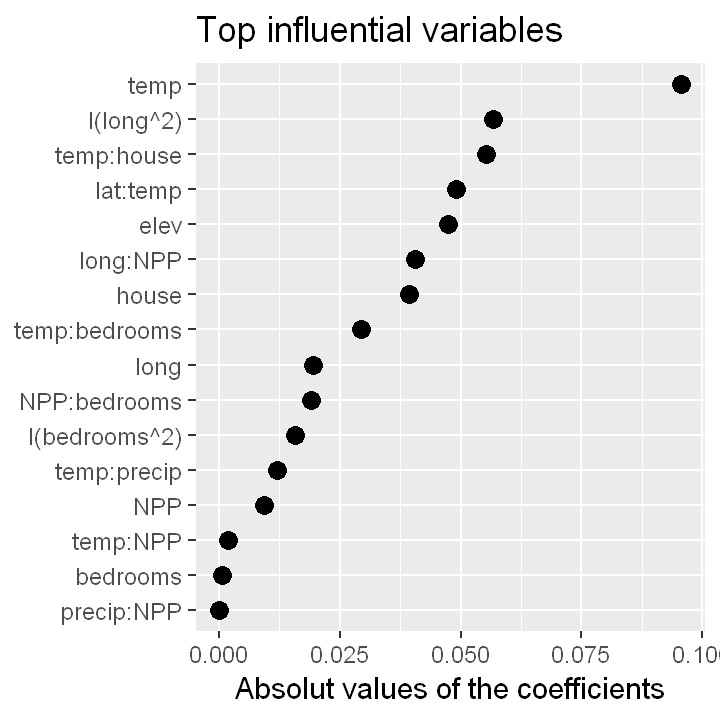

In [64]:
lasso.mod<-glmnet(homes_train_x, homes_train_y, lambda=bestlam, alpha=1, thresh=1e-12)

coefs = abs(coef(lasso.mod, s = "lambda.1se"))

theme_set(theme_gray(base_size = 18))

coefs %>%
  tidy() %>%
  filter(row != "(Intercept)") %>%
  top_n(20, wt = abs(value)) %>%
  ggplot(aes(value, reorder(row, value))) +
  geom_point(size=5) +
  ggtitle("Top influential variables") +
  xlab("Absolut values of the coefficients") +
  ylab(NULL)

The lattitude and long:NPP are cut to zero by the lasso regressor with this lambda value.

In [65]:
abs(coef(lasso.mod, s = "lambda.1se"))

21 x 1 sparse Matrix of class "dgCMatrix"
                         1
(Intercept)   6.119120e+00
long          1.944114e-02
lat           .           
temp          9.572884e-02
precip        .           
NPP           9.339882e-03
elev          4.736849e-02
house         3.930733e-02
bedrooms      6.939304e-04
I(long^2)     5.665210e-02
I(precip^2)   .           
I(NPP^2)      .           
I(bedrooms^2) 1.582766e-02
long:NPP      4.049116e-02
lat:temp      4.900341e-02
temp:precip   1.191359e-02
temp:NPP      1.778360e-03
temp:house    5.523995e-02
temp:bedrooms 2.935178e-02
precip:NPP    1.919859e-06
NPP:bedrooms  1.913358e-02

### Models comparison

In [66]:
#Lasso 
lasso.mod<-glmnet(homes_train_x, homes_train_y, lambda=bestlam, alpha=1, thresh=1e-12)
lasso.pred<-predict(lasso.mod, newx=homes_test_x)
round(mean((lasso.pred-homes_test_y)^2),20)

[1] 0.1471681

In [67]:
#Ridge
ridge.mod<-glmnet(homes_train_x, homes_train_y, lambda=0.01083, alpha=0, thresh=1e-12)
ridge.pred<-predict(ridge.mod, newx=homes_test_x)
round(mean((ridge.pred-homes_test_y)^2),20)

[1] 0.1455603

In [68]:
#OLS
ols.mod<-glmnet(homes_train_x, homes_train_y, lambda=0, alpha=0, thresh=1e-12)
osl.pred<-predict(ols.mod,x=homes_train_x,y=homes_train_y,s=0,newx=homes_test_x,exact=TRUE)
round(mean((osl.pred-homes_test_y)^2),200)

[1] 0.1450428

We also see that lasso and ridge performance is worse for this sample, but we should consider its power avoiding overfit.

**Can you discard further predictor(s) due to the Lasso feature selection property?**

Lasso, is a regression model, but also has a very powerful behaviour. This model, when a reasonable lambda value is used, 'discards' some features. When using lasso, when can induce that these coefficients which are dropped to zero, when we increase the lambda value, are those which are less important in our model.

In some cases, instead of using forward or backward selection, it may be a good idea to use lasso to preselect some features.
In this case, we see that the features NPP and bedrooms are very close to 0 when using the best lambda, latitude and long:NPP have coefficient 0, so we know that those features are not very meaningful in the model.

Note: for the ridge and lasso models we have used some ideas from: https://uc-r.github.io/regularized_regression

## PCR

In statistics, principal component regression (PCR) is a regression analysis technique that is based on principal component analysis (PCA). More specifically, PCR is used for estimating the unknown regression coefficients in a standard linear regression model.

In PCR, instead of regressing the dependent variable on the explanatory variables directly, the principal components of the explanatory variables are used as regressors. One typically uses only a subset of all the principal components for regression, making PCR a kind of regularized procedure and also a type of shrinkage estimator.

https://en.wikipedia.org/wiki/Principal_component_regression

In [69]:
#install.packages("pls",dependencies=TRUE,repos="https://cloud.r-project.org")
require(pls)

Loading required package: pls

Attaching package: 'pls'

The following object is masked from 'package:corrplot':

    corrplot

The following object is masked from 'package:stats':

    loadings



First we can perform a Principal component regression on the features of `homes.ols.01`, and see its performance using cross validation.

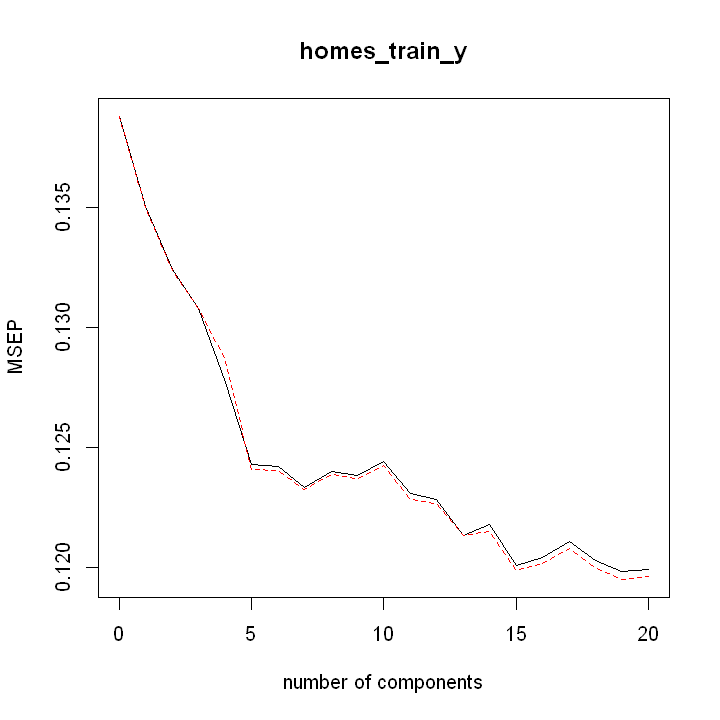

In [70]:
set.seed(1)
pcr.fit<-pcr(homes_train_y~., data=homes_df,scale=TRUE, validation="CV")
validationplot(pcr.fit,val.type="MSEP")

Then we can see which number of components gives us better scores.

In [71]:
cverr <- RMSEP(pcr.fit)$val[1,,]
imin <- which.min(cverr) -1
imin

19 comps 
      19

Now we show the PCR model obtained scores and a summary of the model.

In [72]:
pcr.pred<-predict(pcr.fit,homes_test_x,ncomp=imin)
round(mean((pcr.pred-homes_test_y)^2),20)

pcr.fit<-pcr(homes_train_y~., data=homes_df, scale=TRUE,ncomp=imin)
summary(pcr.fit)

[1] 0.1442307

Data: 	X dimension: 741 20 
	Y dimension: 741 1
Fit method: svdpc
Number of components considered: 19
TRAINING: % variance explained
               1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X               19.867   32.823   43.798   52.480    60.76    67.72    73.74
homes_train_y    2.749    4.749    6.474    8.582    11.53    11.68    12.20
               8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
X                78.72    83.15     87.23     89.64     91.99     94.06
homes_train_y    12.20    12.36     12.39     13.03     13.63     14.25
               14 comps  15 comps  16 comps  17 comps  18 comps  19 comps
X                 96.09     97.71     98.73     99.22     99.58     99.87
homes_train_y     15.06     16.34     16.48     16.49     17.10     17.43


## PLS

Partial least squares regression (PLS regression) is a statistical method that bears some relation to principal components regression; instead of finding hyperplanes of maximum variance between the response and independent variables, it finds a linear regression model by projecting the predicted variables and the observable variables to a new space. Because both the X and Y data are projected to new spaces, the PLS family of methods are known as bilinear factor models. Partial least squares discriminant analysis (PLS-DA) is a variant used when the Y is categorical.

https://en.wikipedia.org/wiki/Partial_least_squares_regression

Now we perform PLS and cross validate the results

In [73]:
set.seed(1)
homes_df = data.frame(cbind(homes_train_y, homes_train_x))
pls.fit<-plsr(homes_train_y~., data=homes_df,scale=TRUE, validation="CV")
summary(pls.fit)

Data: 	X dimension: 741 20 
	Y dimension: 741 1
Fit method: kernelpls
Number of components considered: 20

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV          0.3725   0.3523   0.3486   0.3476   0.3468   0.3465   0.3464
adjCV       0.3725   0.3521   0.3484   0.3473   0.3464   0.3462   0.3460
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV      0.3465   0.3467   0.3467    0.3463    0.3463    0.3463    0.3462
adjCV   0.3461   0.3462   0.3462    0.3458    0.3458    0.3458    0.3458
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps  20 comps
CV       0.3462    0.3462    0.3462    0.3463    0.3463    0.3463    0.3463
adjCV    0.3458    0.3457    0.3458    0.3458    0.3458    0.3458    0.3458

TRAINING: % variance explained
               1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X                15.45    28.55    36.29    43.23    51.28

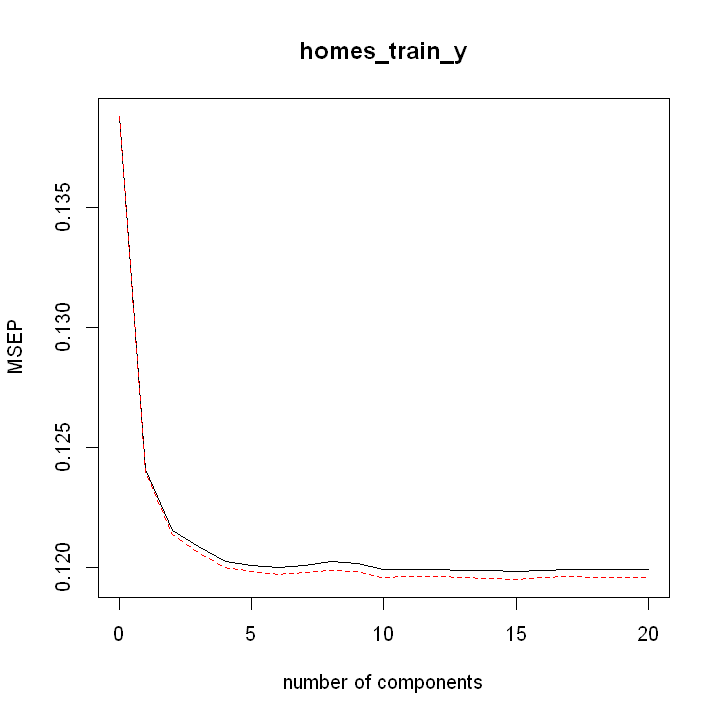

In [74]:
validationplot(pls.fit,val.type="MSEP")

See the number of components which give better results

In [75]:
cverr <- RMSEP(pls.fit)$val[1,,]
imin <- which.min(cverr) - 1
imin

15 comps 
      15

Now we show the model scores and a summary.

In [76]:
pls.pred<-predict(pls.fit,homes_test_x,ncomp=imin)
round(mean((pls.pred-homes_test_y)^2),20)
pls.fit<-plsr(homes_train_y~., data=homes_df, scale=TRUE, ncomp=imin)
summary(pls.fit)


[1] 0.1449556

Data: 	X dimension: 741 20 
	Y dimension: 741 1
Fit method: kernelpls
Number of components considered: 15
TRAINING: % variance explained
               1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X                15.45    28.55    36.29    43.23    51.28    57.51    61.39
homes_train_y    11.89    14.57    16.04    16.79    16.94    17.11    17.32
               8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
X                65.85    70.82     75.46     80.08     83.57     85.72
homes_train_y    17.42    17.47     17.49     17.49     17.50     17.50
               14 comps  15 comps
X                 88.34     89.89
homes_train_y     17.51     17.51


# Used online sources

http://www.sthda.com/english/wiki/correlation-matrix-a-quick-start-guide-to-analyze-format-and-visualize-a-correlation-matrix-using-r-software

https://r-coder.com/correlation-plot-r/https://r-coder.com/correlation-plot-r/

https://www.statmethods.net/advgraphs/parameters.html

https://www.rdocumentation.org/packages/regclass/versions/1.6/topics/VIF

https://uc-r.github.io/regularized_regression

https://statisticaloddsandends.wordpress.com/2018/10/15/obtaining-the-number-of-components-from-cross-validation-of-principal-components-regression/

https://uc-r.github.io/regularized_regression